In this notebook we create a dataframe with parameter sets that sample the parameter space. 

The distribution is a used is a loguniform distribution but the uniform is defined as well. The sampling method is latin hypercube sampling

##### Imports

In [1]:

import pickle
import pandas as pd
import numpy as np
from datetime import date
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


##### Distributions to sample from

In [2]:
#UNIFORM function returns a uniform distribution from 'low' to 'high' of a certain 'size'. 
def uniform(low=-3, high=3, size=None):
    return np.random.uniform(low, high, size)

#LOGUNIFORM function returns a loguniform distribution from 'low' to 'high' of a certain 'size'. 
#In the loguniform distribution, a positive random variable X is log-uniformly distributed if the logarithm of X is uniform distributed. 
#Also called the reciprocal distribution
def loguniform(low=-3, high=3, size=None): 
    return (10) ** (np.random.uniform(low, high, size))


##### Latin Hypercube Sampling algorithm

Latin-Hypercube is an efficient method of sampling to cover efficiently the parameter space by using a only a few samples.

To do this, we separate the space into x sections in every dimension. x is the number of samples desired. For a 2D space, we would obtain a Latin square where no samples can appear in the same column or row (for a 2D space). Such configuration is similar to having N rooks on a chess board without threatening each other. Latin hypercube sampling is a generalisation of this concept to an arbitrary number of dimensions. 

To generate the sectioning of the space, we need to provide an initial distribution in the form of a dataset. This can be done by providing the output of the uniform and loguniform functions. 

(Bergstra et al. 2012; Iman et al. 1980)


In [3]:
def lhs(data, nsample): #data contains the information on the distribution. nsample is the number of samples desired (x). 
    m, nvar = len(data),1
    ran = np.random.uniform(size=(nsample, nvar))
    s = np.zeros((nsample, nvar))
    for j in range(0, nvar):
        idx = np.random.permutation(nsample) + 1
        P = ((idx - ran[:, j]) / nsample) * 100
        s[:, j] = np.percentile(data[:, j], P)
    return s


##### Function that creates dataframe



In [4]:
def parameterfile_creator_function(n_param_sets): #number of parameter sets desired in the df (number of rows)
    #First, an example distribution is created (loguniform or uniform).
    loguniformdist = loguniform(size=1000000) 
    
    #Parameters and their possible ranges
    parameters_lhs = ['c1','c2','c3']
    c1_range = (0.1, 10) 
    c2_range = (1, 100)
    c3_range = (1, 100)
    parameter_range_list = [c1_range,c2_range, c3_range]

    
    #Defining distributions to input into lhs function
    
    #1. Adapt distribution to parameter rangeparameter_distribution_list = []
    parameter_distribution_list = []
    for parameter_range in parameter_range_list: 
        distribution = [x for x in loguniformdist if parameter_range[0] <= x <= parameter_range[1]]
        parameter_distribution_list.append(distribution)
        
    #2. Adapt distributions so they are all of the same lenght
    minimumlenghtdistribution = np.amin([len(x) for x in parameter_distribution_list])
    for count,parameter_distribution in enumerate(parameter_distribution_list):
        globals()[f'{parameters_lhs[count]}_distribution'] =  np.column_stack( (parameter_distribution[:minimumlenghtdistribution])).transpose()


    #Sample using LHS
    c1 = lhs(c1_distribution,n_param_sets)
    c2 = lhs(c2_distribution,n_param_sets)
    c3 = lhs(c3_distribution,n_param_sets)


    #Define constants 
    #1 is the number of columns (if two constants, that would be a 2). 
    #1000 is the value of the constant
    c4 = np.full((n_param_sets, 1), 1000) 
 
    #Define index column to identify parameter sets. 
    index = np.arange(1, n_param_sets + 1, dtype=np.int).reshape(n_param_sets, 1)
    
    #Define dataframe column names. Then concatenate LHS results and constants.
    parameternames = ['index','c1','c2','c3','c4']
    points = np.concatenate((index,c1,c2,c3, c4), 1)
    df = pd.DataFrame(data=points, columns=parameternames)
    df['index'] = df['index'].astype(int)
    df = df.set_index('index')

    return df #number of columns is the number of parameters. number of rows is the number of parameter sets / samples

##### Execute code and functions



Create dataframe and save it as pickle file

In [8]:
n_param_sets = 100 
df = parameterfile_creator_function(n_param_sets)
pickle.dump(df, open('df.pkl', 'wb'))


Print dataframe

In [9]:
df

,c1,c2,c3,c4
index,,,,
1,0.445587,41.650574,48.361761,1000.0
2,0.667728,48.226396,26.241564,1000.0
3,0.152564,1.311921,1.346937,1000.0
4,0.284476,1.628657,91.579369,1000.0
5,3.033083,10.815844,33.478198,1000.0
...,...,...,...,...
96,1.276455,4.686500,22.118476,1000.0
97,0.913298,1.846728,10.193874,1000.0
98,0.228304,8.326357,52.468905,1000.0


Plot to see that df is correct

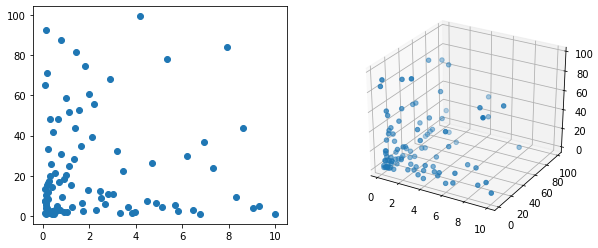

In [10]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(122, projection='3d')

ax.scatter(df['c1'],df['c2'], df['c3'])

ax3 = fig.add_subplot(121)

plt.scatter(df['c1'], df['c2'])
plt.show()